Just gettin' started!

In [192]:
import pandas as pd
import os
import shutil
import random
from pathlib import Path
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications.resnet50 import preprocess_input


In [193]:
# Load the FairFace CSV file
df = pd.read_csv("data/fairface_label_train.csv")

In [194]:
df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [195]:
df.shape

(86744, 5)

In [196]:
df['age'].unique()

array(['50-59', '30-39', '3-9', '20-29', '40-49', '10-19', '60-69', '0-2',
       'more than 70'], dtype=object)

In [197]:
# It's highly unlikely that kids under the age of 20 are working in this organization.
df = df[~df['age'].isin(['0-2', '3-9', '10-19'])]

In [198]:
df.shape

(65441, 5)

In [199]:
print(df['race'].unique())
print(df['gender'].unique())

['East Asian' 'Indian' 'White' 'Middle Eastern' 'Latino_Hispanic'
 'Southeast Asian' 'Black']
['Male' 'Female']


In [200]:
# Stratified sampling: race × gender
# samples_per_group = 500

# df_balanced = (
#     df.groupby(['race', 'gender']).apply(
#         lambda x: x.sample(min(len(x), samples_per_group), random_state=42).assign(race=x['race'].iloc[0], gender=x['gender'].iloc[0]),
#         include_groups=False
#     )
#     .reset_index(drop=True)
# )
samples_per_group = 500

grouped = df.groupby(['race', 'gender'], group_keys=False)
df_balanced = pd.concat([
    group.sample(min(len(group), samples_per_group), random_state=42)
    for _, group in grouped
], ignore_index=True)

In [201]:
group_counts = df_balanced.groupby(['race', 'gender']).size().reset_index(name='count')
print(group_counts)

               race  gender  count
0             Black  Female    500
1             Black    Male    500
2        East Asian  Female    500
3        East Asian    Male    500
4            Indian  Female    500
5            Indian    Male    500
6   Latino_Hispanic  Female    500
7   Latino_Hispanic    Male    500
8    Middle Eastern  Female    500
9    Middle Eastern    Male    500
10  Southeast Asian  Female    500
11  Southeast Asian    Male    500
12            White  Female    500
13            White    Male    500


In [202]:
print(df_balanced.columns)

Index(['file', 'age', 'gender', 'race', 'service_test'], dtype='object')


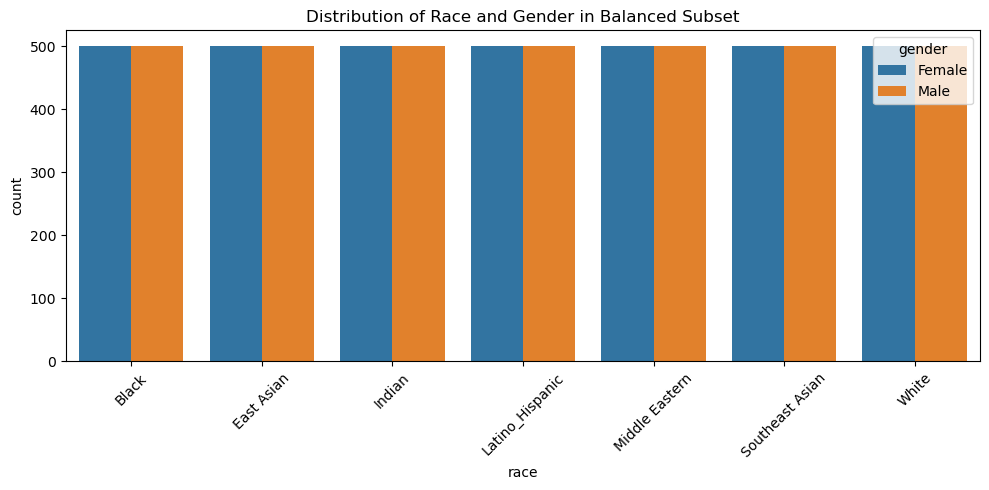

In [203]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced, x='race', hue='gender')
plt.title('Distribution of Race and Gender in Balanced Subset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [204]:
# Save selected subset
df_balanced.to_csv("data/fairface_subset.csv", index=False)

In [205]:
# # Copy images to output folder
# src_img_dir = "data/fairface-img-margin125-trainval/train"
# dst_img_dir = "dataset/human/"
# os.makedirs(dst_img_dir, exist_ok=True)

# # Strip 'train/' prefix from file column if present
# df_balanced['file'] = df_balanced['file'].apply(lambda x: os.path.basename(x))

# for img in df_balanced['file']:
#     src_path = os.path.join(src_img_dir, img)
#     dst_path = os.path.join(dst_img_dir, img)
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)

In [206]:
# Define source paths
fairface_dir = Path("DATA/fairface-img-margin125-trainval/train")
cat_dir = Path("DATA/animal-faces/afhq/train/cat")
dog_dir = Path("DATA/animal-faces/afhq/train/dog")

# Define destination paths
dest_human = Path("DATA/binary_classifier/train/human")
dest_animal = Path("DATA/binary_classifier/train/animal")
dest_human.mkdir(parents=True, exist_ok=True)
dest_animal.mkdir(parents=True, exist_ok=True)

# Select 7000 random human faces
human_files = list(fairface_dir.glob("*.jpg"))
selected_human = random.sample(human_files, 7000)
for file in selected_human:
    shutil.copy(file, dest_human / file.name)

# Select 3500 random cat and dog faces
cat_files = list(cat_dir.glob("*.jpg"))
dog_files = list(dog_dir.glob("*.jpg"))
selected_cats = random.sample(cat_files, 3500)
selected_dogs = random.sample(dog_files, 3500)

# Copy to animal class
for file in selected_cats + selected_dogs:
    shutil.copy(file, dest_animal / file.name)

print("Dataset creation complete.")

Dataset creation complete.


In [207]:
# Define new source paths for validation
fairface_val_dir = Path("DATA/fairface-img-margin125-trainval/val")
cat_val_dir = Path("DATA/animal-faces/afhq/val/cat")
dog_val_dir = Path("DATA/animal-faces/afhq/val/dog")

# Define new destination paths for validation set
dest_val_human = Path("DATA/binary_classifier/val/human")
dest_val_animal = Path("DATA/binary_classifier/val/animal")
dest_val_human.mkdir(parents=True, exist_ok=True)
dest_val_animal.mkdir(parents=True, exist_ok=True)

# Select 300 random human face images for validation
val_human_files = list(fairface_val_dir.glob("*.jpg"))
selected_val_human = random.sample(val_human_files, 300)
for file in selected_val_human:
    shutil.copy(file, dest_val_human / file.name)

# Select 150 each from cat and dog validation sets
val_cat_files = list(cat_val_dir.glob("*.jpg"))
val_dog_files = list(dog_val_dir.glob("*.jpg"))
selected_val_cats = random.sample(val_cat_files, 150)
selected_val_dogs = random.sample(val_dog_files, 150)

# Copy to animal validation set
for file in selected_val_cats + selected_val_dogs:
    shutil.copy(file, dest_val_animal / file.name)

print("Validation set creation complete.")

Validation set creation complete.


In [208]:
# Set parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATA_DIR = "DATA/binary_classifier"

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

# Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{DATA_DIR}/val",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extract class names BEFORE applying prefetch
class_names = train_ds.class_names
print(class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 44312 files belonging to 2 classes.
Found 2566 files belonging to 2 classes.
['animal', 'human']


In [209]:
# Define augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])


model = models.Sequential([
    Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),  # ✅ correct
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [210]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 249s 178ms/step - accuracy: 0.9391 - loss: 0.1543 - val_accuracy: 0.9934 - val_loss: 0.0184
Epoch 2/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 249s 180ms/step - accuracy: 0.9917 - loss: 0.0235 - val_accuracy: 0.9957 - val_loss: 0.0151
Epoch 3/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 248s 179ms/step - accuracy: 0.9941 - loss: 0.0187 - val_accuracy: 0.9957 - val_loss: 0.0131
Epoch 4/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 256s 185ms/step - accuracy: 0.9951 - loss: 0.0148 - val_accuracy: 0.9945 - val_loss: 0.0165
Epoch 5/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 272s 192ms/step - accuracy: 0.9950 - loss: 0.0149 - val_accuracy: 0.9961 - val_loss: 0.0135
Epoch 6/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 258s 186ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9973 - val_loss: 0.0069
Epoch 7/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 251s 181ms/step - accuracy: 0.9966 - loss: 0.0084 - val_accuracy: 0.9984 - val_loss: 0.0056
Epoch 9/10
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 238s 172ms/step - ac

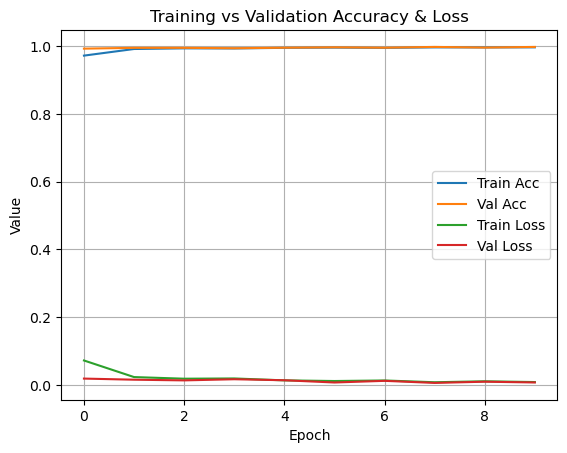

In [211]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [212]:
y_true = []
y_pred = []

for images, labels in val_ds.unbatch().batch(32):
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━

In [213]:
# Define image path and target size
img_path = "data\\my_pics\\20091001_044700000_iOS.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [214]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.99292874
Predicted class: animal


Predicted class: human


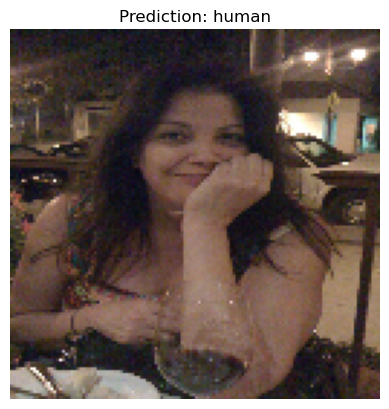

In [215]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [216]:
# Define image path and target size
img_path = "data\\my_pics\\20201225_185146443_iOS.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [217]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
pred_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.9898893
Predicted class: human


Predicted class: human


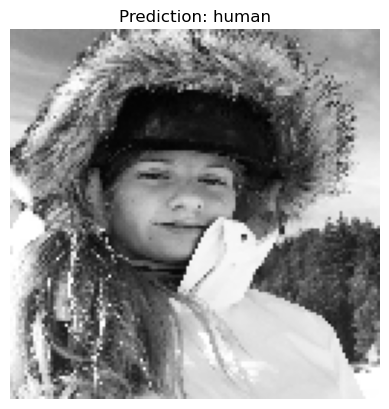

In [218]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [219]:
# Define image path and target size
img_path = "data\\my_pics\\Screenshot 2025-07-20 175956.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [220]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.9932005
Predicted class: human


Predicted class: human


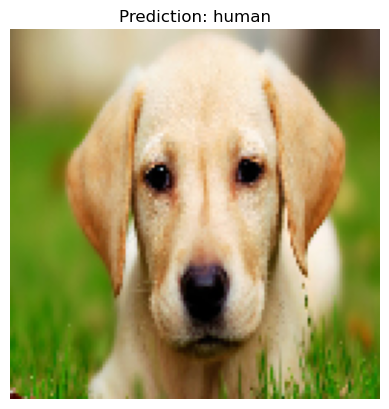

In [221]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [222]:
# Define image path and target size
img_path = "data\\my_pics\\Screenshot 2025-07-20 175818.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [223]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.9830573
Predicted class: human


Predicted class: human


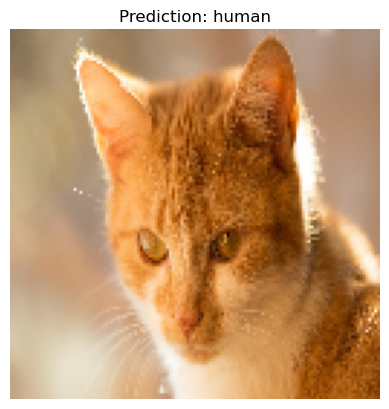

In [224]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

# Transfer Learning with ResNet50

In [225]:
# Rebuild your datasets using ResNet50 preprocessing
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    "DATA/binary_classifier/train",
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
).map(lambda x, y: (preprocess_input(x), y))

val_ds = image_dataset_from_directory(
    "DATA/binary_classifier/val",
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(lambda x, y: (preprocess_input(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # freeze pretrained layers

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Found 44312 files belonging to 2 classes.
Found 2566 files belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [226]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 568s 405ms/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 1.4058e-04
Epoch 2/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 560s 404ms/step - accuracy: 1.0000 - loss: 1.7734e-04 - val_accuracy: 1.0000 - val_loss: 8.2449e-05
Epoch 3/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 555s 401ms/step - accuracy: 1.0000 - loss: 6.0744e-05 - val_accuracy: 1.0000 - val_loss: 4.0983e-05
Epoch 4/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 560s 404ms/step - accuracy: 1.0000 - loss: 1.2118e-04 - val_accuracy: 1.0000 - val_loss: 5.6440e-05
Epoch 5/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 559s 403ms/step - accuracy: 1.0000 - loss: 2.2657e-05 - val_accuracy: 1.0000 - val_loss: 5.2710e-05


In [227]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = int(pred[0][0] > 0.5)
    print(f"Predicted: {class_names[label]} ({pred[0][0]:.4f})")

    plt.imshow(image.load_img(img_path))
    plt.title(f"{class_names[label]} ({pred[0][0]:.4f})")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted: human (1.0000)


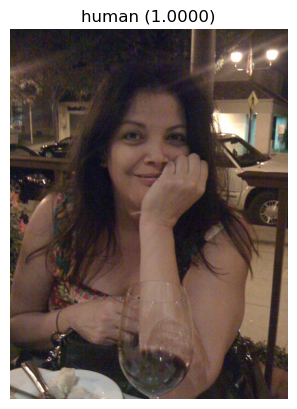

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted: human (1.0000)


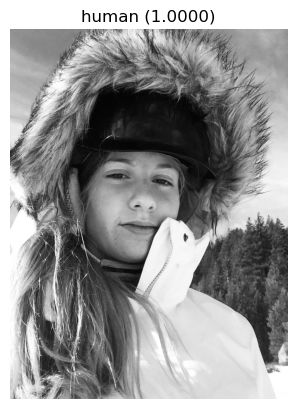

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted: animal (0.0000)


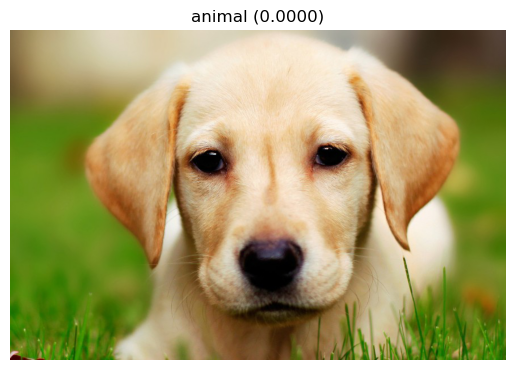

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted: animal (0.0000)


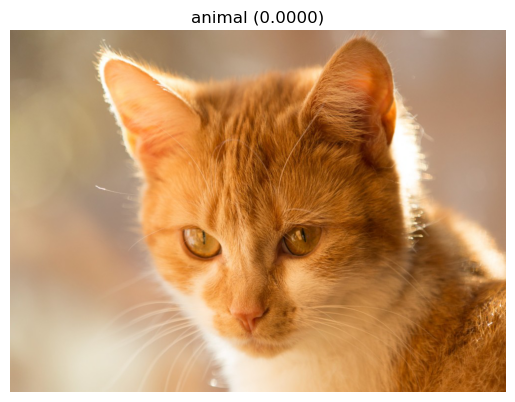

In [229]:
predict_image("data\\my_pics\\20091001_044700000_iOS.jpg")
predict_image("data\\my_pics\\20201225_185146443_iOS.jpg")
predict_image("data\\my_pics\\Screenshot 2025-07-20 175956.jpg")
predict_image("data\\my_pics\\Screenshot 2025-07-20 175818.jpg")